## First of all I loaded all the data into Snowflake database for easier manipulation
I made a simple datamart with snap dates '2020-09-08' for training
and '2020-09-15' for testing, datamart was exported in one csv file named
model_build_base.csv

#### The train set contains following data:
* 259916 rows of SOLD=1 -> All transactions that were sold in week '2020-09-08' to '2020-09-15'
* 1000000 randomly chosen combinations of customer_id and article_id that were not sold that week with SOLD=0
* All article information, customer information and customer transaction history info is also joined

#### The test set contains following data:
* All the same as train set just shifted one week forward for week between '2020-09-15' and '2020-09-22'



#### Fitting
A simple XGBoost model was fitted


In [10]:
#importing custom library
#!pip install git+https://github.com/Vrboska/mofr@master

In [11]:
import pandas as pd
import numpy as np
import random
import mofr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_absolute_error,mean_squared_error, mean_squared_log_error)
from xgboost import XGBClassifier, plot_tree
import math

import xgboost as xgb
import hyperopt

In [12]:
seed=1234

In [13]:
df=pd.read_csv('/kaggle/input/hm-model-build-base/model_build_base.csv').fillna(0)

In [14]:
len(df)

2496538

In [15]:
# #removing bads due to capacity issues (at the end we train with full data though)
# remove_n = 3000000
# drop_indices = np.random.choice(df[df['SOLD']==0].index, remove_n, replace=False)
# df = df.drop(drop_indices)
#len(df)

In [16]:
len(df)

2496538

In [17]:
del df['CUSTOMER_ID1']
del df['CUSTOMER_ID2']
del df['CUSTOMER_ID3']
del df['CUSTOMER_ID4']
del df['CUSTOMER_ID5']
del df['CUSTOMER_ID6']
del df['Unnamed: 0']

In [18]:
df.head()

,SOLD,ARTICLE_ID,SNAP_DATE,CUSTOMER_ID,ACTIVE,CLUB_MEMBER_STATUS,FASHION_NEWS_FREQUENCY,AGE,QUANT_PG_ACCESSORIES_1M,QUANT_PG_BAGS_1M,...,QUANT_INDEX_DIVIDED_12M,QUANT_INDEX_LADIESWEAR_12M,QUANT_INDEX_MENSWEAR_12M,QUANT_INDEX_SPORT_12M,PRODUCT_GROUP_NAME,COLOUR,PERCEIVED_COLOUR,INDEX_CODE,INDEX_GROUP_NO,GARMENT_GROUP_NO
0,0,762133002,2020-09-08,de36919d41ca2910f5e6e0aeb41bb41c205d198789c957...,0.0,ACTIVE,NONE,40.0,0.0,0.0,...,9.0,20.0,0.0,6.0,Nightwear,BLUE,Dusty Light,B,1,1017
1,0,828921002,2020-09-08,1e701b09d93be63067a243e24a67b3c85f187829bb1e0f...,1.0,ACTIVE,Regularly,28.0,0.0,0.0,...,0.0,15.0,0.0,0.0,Garment Lower body,OTHER,Medium Dusty,G,4,1006
2,0,912092002,2020-09-08,52cc1e1fea541e968aa7caabce6ea87cf7178a9b3a5b5d...,0.0,ACTIVE,NONE,17.0,0.0,0.0,...,0.0,0.0,0.0,0.0,Garment Full body,BLACK,Dark,A,1,1005
3,0,630325008,2020-09-08,496ca06798fa0101a4fe4621ce8ba3e1f53b783972c3e2...,1.0,ACTIVE,Regularly,69.0,0.0,0.0,...,0.0,1.0,0.0,0.0,Garment Upper body,WHITE,Light,F,3,1005
4,0,568652018,2020-09-08,2de614cdf7886b29d3ede9822ea373f6970a385b41e98c...,0.0,ACTIVE,NONE,26.0,0.0,0.0,...,9.0,49.0,1.0,0.0,Accessories,GREEN,Medium,C,1,1019


In [19]:
df['CLUB_MEMBER_STATUS']=df['CLUB_MEMBER_STATUS'].replace(0, np.nan)
df['FASHION_NEWS_FREQUENCY']=df['FASHION_NEWS_FREQUENCY'].replace(0, np.nan)

In [20]:
train_mask=df['SNAP_DATE']=='2020-09-08'
valid_mask=df['SNAP_DATE']=='2020-09-15'

In [21]:
df[train_mask]['SOLD'].value_counts()

0    1000000
1     259916
Name: SOLD, dtype: int64

In [22]:
df[valid_mask]['SOLD'].value_counts()

0    1000000
1     236622
Name: SOLD, dtype: int64

# Data Exploration

In [23]:
df[train_mask].describe()

,SOLD,ARTICLE_ID,ACTIVE,AGE,QUANT_PG_ACCESSORIES_1M,QUANT_PG_BAGS_1M,QUANT_PG_COSMETIC_1M,QUANT_PG_FUN_1M,QUANT_PG_FURNITURE_1M,QUANT_PG_GFB_1M,...,QUANT_INDEX_LADIESWEAR_1M,QUANT_INDEX_MENSWEAR_1M,QUANT_INDEX_SPORT_1M,QUANT_INDEX_BABYCHILDREN_12M,QUANT_INDEX_DIVIDED_12M,QUANT_INDEX_LADIESWEAR_12M,QUANT_INDEX_MENSWEAR_12M,QUANT_INDEX_SPORT_12M,INDEX_GROUP_NO,GARMENT_GROUP_NO
count,1.259916e+06,1.259916e+06,1.259916e+06,1.259916e+06,1.259916e+06,1.259916e+06,1.259916e+06,1259916.0,1259916.0,1.259916e+06,...,1.259916e+06,1.259916e+06,1.259916e+06,1.259916e+06,1.259916e+06,1.259916e+06,1.259916e+06,1.259916e+06,1.259916e+06,1.259916e+06
mean,2.062963e-01,7.217992e+08,4.484958e-01,3.545625e+01,1.678318e-01,2.387461e-03,1.190556e-05,0.0,0.0,4.321756e-01,...,2.336853e+00,1.953852e-01,1.796596e-01,8.033361e-01,7.171283e+00,2.224231e+01,1.799054e+00,1.309304e+00,3.113679e+00,1.010222e+03
std,4.046458e-01,1.363477e+08,4.973404e-01,1.408830e+01,6.600916e-01,5.218290e-02,3.450424e-03,0.0,0.0,1.682844e+00,...,4.717211e+00,1.055293e+00,9.301393e-01,3.032925e+00,1.227703e+01,3.103859e+01,4.776568e+00,3.520030e+00,4.695089e+00,6.644287e+00
min,0.000000e+00,1.087750e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.001000e+03
25%,0.000000e+00,6.298970e+08,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.005000e+03
50%,0.000000e+00,7.324090e+08,0.000000e+00,3.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.300000e+01,0.000000e+00,0.000000e+00,2.000000e+00,1.009000e+03
75%,0.000000e+00,8.319430e+08,1.000000e+00,4.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,...,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,2.900000e+01,1.000000e+00,1.000000e+00,4.000000e+00,1.017000e+03
max,1.000000e+00,9.594610e+08,1.000000e+00,9.600000e+01,2.600000e+01,3.000000e+00,1.000000e+00,0.0,0.0,8.900000e+01,...,1.070000e+02,5.700000e+01,7.000000e+01,7.600000e+01,3.920000e+02,7.510000e+02,1.070000e+02,2.220000e+02,2.600000e+01,1.025000e+03


In [24]:
df[train_mask].describe(include=['O'])

,SNAP_DATE,CUSTOMER_ID,CLUB_MEMBER_STATUS,FASHION_NEWS_FREQUENCY,PRODUCT_GROUP_NAME,COLOUR,PERCEIVED_COLOUR,INDEX_CODE
count,1259916,1259916,1258122,1256553,1259916,1259916,1259916,1259916
unique,1,80765,3,3,19,12,8,10
top,2020-09-08,e7cd5bad25c91d7922ee15ab487f03714177f6b0fd275f...,ACTIVE,NONE,Garment Upper body,BLACK,Dark,A
freq,1259916,62,1244110,682044,531802,309281,527709,366959


# Data transformations

In [25]:
col_target='SOLD'
col_exclude=[
'SNAP_DATE',
'CUSTOMER_ID',
'ARTICLE_ID',

col_target,
    
# 'BAYES_INDEX_CODE',
# 'BAYES_COLOUR',
# 'BAYES_PRODUCT_GROUP_NAME',
# 'BAYES_PERCEIVED_COLOUR',
# 'GARMENT_GROUP_NO',
# 'INDEX_GROUP_NO'
]

## Categorical transformations

In [26]:
import category_encoders as ce

In [27]:
# potential predictors without encoding
cat_preds = [col for col in df.select_dtypes(include="object") if col not in col_exclude]
bool_preds = [col for col in df.select_dtypes(include="bool") if col not in col_exclude]
datetime_preds = [col for col in df.select_dtypes(include="datetime") if col not in col_exclude]

### Target Encoding

In [28]:
# # bayesian target encoding
encoder = ce.TargetEncoder(min_samples_leaf=1, smoothing=1.0)
encoder.fit_transform(df[train_mask][cat_preds], df[train_mask][col_target])

df = pd.concat([df, encoder.transform(df[cat_preds]).add_prefix("BAYES_")], axis=1)

/opt/conda/lib/python3.7/site-packages/category_encoders/target_encoder.py:124: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/opt/conda/lib/python3.7/site-packages/category_encoders/target_encoder.py:129: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


In [29]:
col_preds=[col for col in df.select_dtypes(include=["int","float"]) if col not in col_exclude]

In [30]:
len(col_preds)

80

# Fitting models

In [31]:
(df[train_mask][col_target]>0).value_counts(normalize=True)

False    0.793704
True     0.206296
Name: SOLD, dtype: float64

## XGBoost model

In [32]:
xgb_model = XGBClassifier(max_depth=4, seed=seed, colsample_bytree=0.5, gamma=1, min_child_weight=5, n_estimators=100)
xgb_model.fit(df[train_mask].loc[:, col_preds], df[train_mask][col_target], verbose=0, eval_metric='logloss')


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1234, reg_alpha=0, reg_lambda=1, ...)

In [33]:
df['XGB_SCORE']=xgb_model.predict_proba(df[col_preds])[:, 1]

In [34]:
print('The Lift on the train set is: '+ str(mofr.metrics.lift(df[train_mask][col_target], df[train_mask]['XGB_SCORE'])))
print('The gini on the train set is: '+ str(mofr.metrics.gini(df[train_mask][col_target], df[train_mask]['XGB_SCORE'])))
print('The accuracy on the train set is: '+ str(mofr.metrics.accuracy_score(df[train_mask][col_target], df[train_mask]['XGB_SCORE'].apply(lambda x: int(x>0.5)))))
print('\n')
print('The Lift on the valid set is: '+ str(mofr.metrics.lift(df[valid_mask][col_target], df[valid_mask]['XGB_SCORE'])))
print('The gini on the valid set is: '+ str(mofr.metrics.gini(df[valid_mask][col_target], df[valid_mask]['XGB_SCORE'])))
print('The accuracy on the valid set is: '+ str(mofr.metrics.accuracy_score(df[valid_mask][col_target], df[valid_mask]['XGB_SCORE'].apply(lambda x: int(x>0.5)))))

The Lift on the train set is: 3.265698553355625
The gini on the train set is: 0.7084577638083074
The accuracy on the train set is: 0.8287377888684643


The Lift on the valid set is: 3.3057116285649886
The gini on the valid set is: 0.698680259422201
The accuracy on the valid set is: 0.8347102024709249


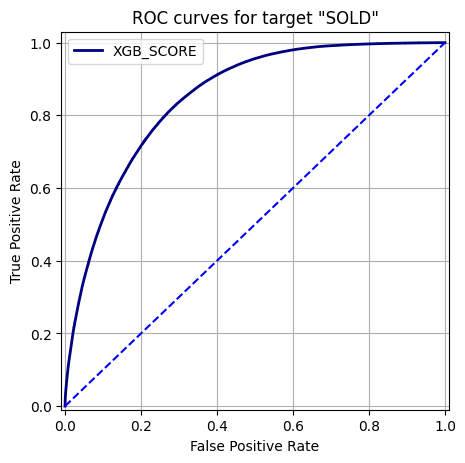

In [35]:
from mofr.basic_evaluators.ROCCurve import ROCCurveEvaluator
df['one']=1

rce=ROCCurveEvaluator()
rce.d(df[valid_mask]).t([(col_target,'one')]).s(['XGB_SCORE'])
rce.get_graph()

del df['one']

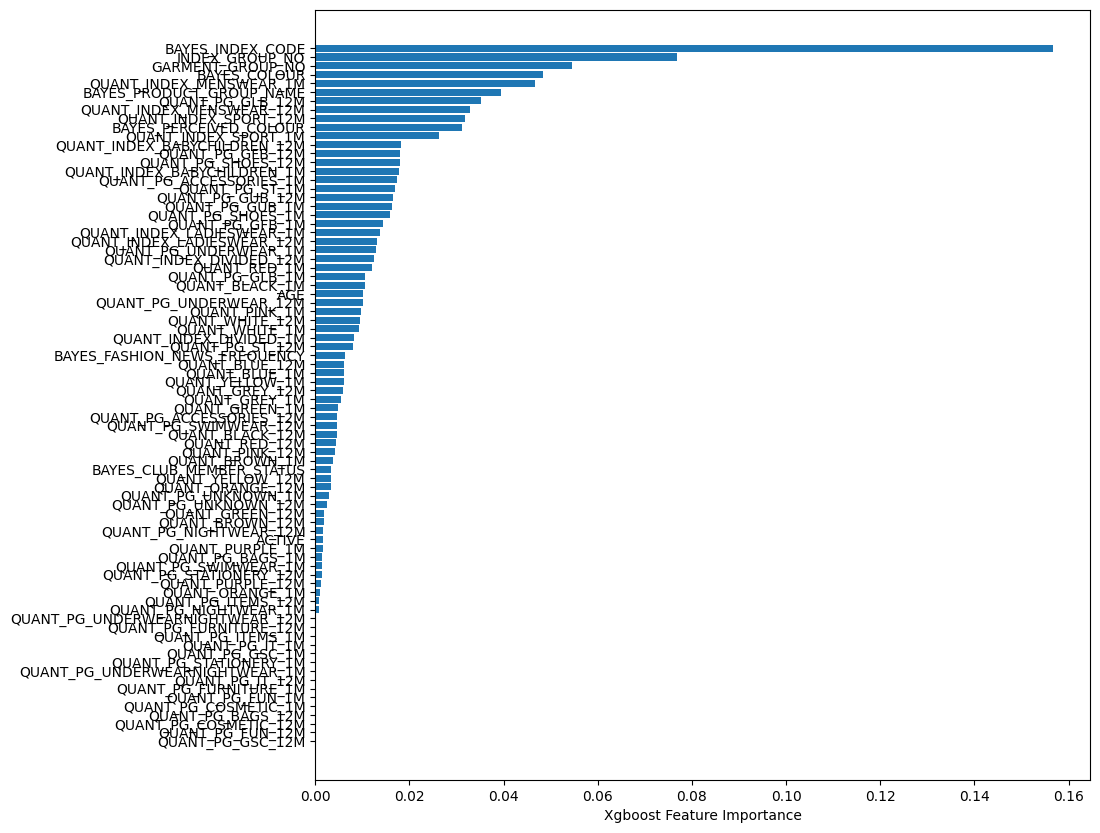

In [36]:
sorted_idx = xgb_model.feature_importances_.argsort()
order_ = []
for i in sorted_idx:
  order_.append(col_preds[i])
plt.figure(figsize=(10, 10))
fig = plt.barh(order_, xgb_model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

In [37]:
results=[]
for col in col_preds:
    results.append((col, np.abs(mofr.metrics.gini(df[valid_mask][col_target], df[valid_mask][col]))))
  
pd.DataFrame(results, columns=['Predictor', 'GINI']).sort_values(by='GINI', ascending=False)[0:30]

,Predictor,GINI
79,BAYES_INDEX_CODE,0.432550
72,INDEX_GROUP_NO,0.344170
77,BAYES_COLOUR,0.274300
76,BAYES_PRODUCT_GROUP_NAME,0.181477
78,BAYES_PERCEIVED_COLOUR,0.131053
28,QUANT_PG_GLB_12M,0.098327
69,QUANT_INDEX_LADIESWEAR_12M,0.097358
51,QUANT_BLACK_12M,0.096806
27,QUANT_PG_GUB_12M,0.094527
68,QUANT_INDEX_DIVIDED_12M,0.093404


### Saving the model

In [38]:
import pickle
file_name = "hm_xgb_model.pkl"

# save
pickle.dump(xgb_model, open(file_name, "wb"))

# # load
# #xgb_model_loaded = pickle.load(open(file_name, "rb"))

# Additional checks

In [39]:
df.head()

,SOLD,ARTICLE_ID,SNAP_DATE,CUSTOMER_ID,ACTIVE,CLUB_MEMBER_STATUS,FASHION_NEWS_FREQUENCY,AGE,QUANT_PG_ACCESSORIES_1M,QUANT_PG_BAGS_1M,...,INDEX_CODE,INDEX_GROUP_NO,GARMENT_GROUP_NO,BAYES_CLUB_MEMBER_STATUS,BAYES_FASHION_NEWS_FREQUENCY,BAYES_PRODUCT_GROUP_NAME,BAYES_COLOUR,BAYES_PERCEIVED_COLOUR,BAYES_INDEX_CODE,XGB_SCORE
0,0,762133002,2020-09-08,de36919d41ca2910f5e6e0aeb41bb41c205d198789c957...,0.0,ACTIVE,NONE,40.0,0.0,0.0,...,B,1,1017,0.206562,0.208981,0.158568,0.120377,0.216554,0.306366,0.150088
1,0,828921002,2020-09-08,1e701b09d93be63067a243e24a67b3c85f187829bb1e0f...,1.0,ACTIVE,Regularly,28.0,0.0,0.0,...,G,4,1006,0.206562,0.203330,0.233927,0.261318,0.245011,0.025469,0.032126
2,0,912092002,2020-09-08,52cc1e1fea541e968aa7caabce6ea87cf7178a9b3a5b5d...,0.0,ACTIVE,NONE,17.0,0.0,0.0,...,A,1,1005,0.206562,0.208981,0.143793,0.305091,0.233187,0.329083,0.119332
3,0,630325008,2020-09-08,496ca06798fa0101a4fe4621ce8ba3e1f53b783972c3e2...,1.0,ACTIVE,Regularly,69.0,0.0,0.0,...,F,3,1005,0.206562,0.203330,0.238907,0.214769,0.163729,0.115690,0.038390
4,0,568652018,2020-09-08,2de614cdf7886b29d3ede9822ea373f6970a385b41e98c...,0.0,ACTIVE,NONE,26.0,0.0,0.0,...,C,1,1019,0.206562,0.208981,0.108735,0.177097,0.070530,0.182325,0.148830


## Categorical encoding check

In [40]:
pd.DataFrame(df.groupby(['INDEX_CODE', 'BAYES_INDEX_CODE'])['SOLD'].agg(['count','mean', 'sum']))

,,count,mean,sum
INDEX_CODE,BAYES_INDEX_CODE,,,
A,0.329083,721375,0.317642,229139
B,0.306366,181966,0.302133,54978
C,0.182325,158960,0.178668,28401
D,0.295000,403514,0.288488,116409
F,0.115690,268188,0.107589,28854
G,0.025469,173678,0.024436,4244
H,0.010883,233912,0.010380,2428
I,0.019189,175911,0.017026,2995
J,0.006773,88757,0.007143,634


In [41]:
pd.DataFrame(df.groupby(['PRODUCT_GROUP_NAME', 'BAYES_PRODUCT_GROUP_NAME'])['SOLD'].agg(['count','mean', 'sum']))

,,count,mean,sum
PRODUCT_GROUP_NAME,BAYES_PRODUCT_GROUP_NAME,,,
Accessories,1.087347e-01,233074,0.111106,25896
Bags,4.685990e-01,653,0.509954,333
Cosmetic,4.405286e-03,815,0.007362,6
Fun,6.666678e-02,134,0.029851,4
Furniture,0.000000e+00,228,0.000000,0
Garment Full body,1.437930e-01,294231,0.137647,40500
Garment Lower body,2.339267e-01,484179,0.224857,108871
Garment Upper body,2.389066e-01,1051216,0.229462,241214
Garment and Shoe care,2.298851e-02,161,0.018634,3


In [42]:
pd.DataFrame(df.groupby(['COLOUR', 'BAYES_COLOUR'])['SOLD'].agg(['count','mean', 'sum']))

,,count,mean,sum
COLOUR,BAYES_COLOUR,,,
BLACK,0.305091,605760,0.299397,181363
BLUE,0.120377,395321,0.115127,45512
BROWN,0.181596,34600,0.172832,5980
GREEN,0.177097,149697,0.166617,24942
GREY,0.209211,227381,0.201552,45829
ORANGE,0.191810,77268,0.181317,14010
OTHER,0.261318,290298,0.251852,73112
PINK,0.124399,205124,0.117251,24051
PURPLE,0.298805,30861,0.281780,8696


## SHAP values

In [43]:
import shap  # package used to calculate Shap values

In [44]:
row_to_show = 0
data_for_prediction = df[train_mask][col_preds].iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(xgb_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction_array)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [45]:
# shap_values = explainer.shap_values(df[train_mask][col_preds])
# shap.summary_plot(shap_values, df[train_mask][col_preds])

# Future predictions part

Simple article preselection approach was chosen-> top 1000 articles by average XGB_SCORE 

In [46]:
suggested_items=pd.DataFrame(df.groupby(['ARTICLE_ID'])['XGB_SCORE'].mean()).reset_index().sort_values('XGB_SCORE', ascending=False)[0:100]

In [47]:
articles=df[train_mask][[
 'ARTICLE_ID' ,  
 'INDEX_GROUP_NO',
 'GARMENT_GROUP_NO',
 'BAYES_PRODUCT_GROUP_NAME',
 'BAYES_COLOUR',
 'BAYES_PERCEIVED_COLOUR',
 'BAYES_INDEX_CODE']].drop_duplicates()

In [48]:
del df

In [49]:
suggested_items=suggested_items.merge(articles, how='left', on='ARTICLE_ID')

In [50]:
del suggested_items['XGB_SCORE']

In [51]:
suggested_items

,ARTICLE_ID,INDEX_GROUP_NO,GARMENT_GROUP_NO,BAYES_PRODUCT_GROUP_NAME,BAYES_COLOUR,BAYES_PERCEIVED_COLOUR,BAYES_INDEX_CODE
0,902802001,26,1005,0.756237,0.305091,0.233187,0.319996
1,730683050,26,1005,0.756237,0.305091,0.233187,0.319996
2,852584001,26,1005,0.756237,0.305091,0.233187,0.319996
3,880821001,1,1008,0.756237,0.261318,0.216554,0.329083
4,867969003,2,1016,0.756237,0.120377,0.163729,0.295000
...,...,...,...,...,...,...,...
95,708869002,1,1017,0.238907,0.261318,0.216554,0.329083
96,889828005,1,1002,0.238907,0.298805,0.216554,0.329083
97,678942059,1,1017,0.238907,0.261318,0.245011,0.329083
98,804732003,1,1017,0.233927,0.305091,0.233187,0.329083


## Scoring customers in batches to produce submission file
For each of the 1000 suggested items and for each customer, then ordering and picking top 12

In [52]:
submission=pd.DataFrame()

In [105]:
def process_chunk(chunk):
    chunk=chunk.merge(suggested_items, how='cross')
    chunk['XGB_SCORE']=xgb_model.predict_proba(chunk[col_preds])[:, 1]
    chunk['ARTICLE_ID']=chunk['ARTICLE_ID'].apply(str).apply(lambda x: x.zfill(10))
    a=chunk[['CUSTOMER_ID', 'ARTICLE_ID', 'XGB_SCORE']].groupby('CUSTOMER_ID').apply(lambda x : x.sort_values(by = 'XGB_SCORE', ascending = False).head(12).reset_index(drop = True)).reset_index(drop = True)
    b=pd.DataFrame(a.groupby('CUSTOMER_ID')['ARTICLE_ID'].apply(list).apply(' '.join)).reset_index(drop=False).rename(columns={'ARTICLE_ID':'PREDICTION'})
    return a
    
    

In [ ]:
n=0
chunksize = 10 ** 4
with pd.read_csv('/kaggle/input/hm-model-build-base/model_submission_base.csv', chunksize=chunksize) as reader:
    for chunk in reader:
        print(n)
        submission=pd.concat([submission,process_chunk(chunk)])
        n+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


In [ ]:
submission.to_csv('submission.csv', index=False)